In [152]:
import numpy as np
import os
import time
import scipy
import glob
import sys
from datetime import datetime
import matplotlib as mpl
mpl.use('nbagg')
import seaborn as sns
import pylab as pl

import importlib
import pandas as pd
import scipy.stats as spstats

# import some custom funcs
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import utils as util
import behavior as butil
import plotting as putil
import google_drive as gdrive

from matplotlib.gridspec import GridSpec

import matplotlib.gridspec as gridspec
import stats as st

import trajectory as traj
import _pickle as pkl

In [159]:
importlib.reload(util)
util.set_sns_style(style='dark')
%matplotlib notebook

In [160]:
rootdir = util.get_rootdir()
rootdir

'/home/julianarhee/edgetracking-googledrive/Edge_Tracking/Data'

In [161]:
rootdir = util.get_rootdir()
#experiment = '15-degree'
experiment = 'T-plume'


if experiment=='45-degree':
    exp_folder = '45 degree plume'
else:
    exp_folder = experiment
srcdir = os.path.join(rootdir.replace('Data', 'Analysis'), exp_folder)
print(srcdir)
# # src_dir = '/Users/julianarhee/Documents/rutalab/data/test'
# print(src_dir)
# fig_id = os.path.join('/Edge_Tracking', rootdir.split('/Edge_Tracking/')[1], experiment)
# print(fig_id)
savedir = os.path.join(rootdir, 'jyr', 'plume_geometries', 'data')
print(savedir)
# savedir = savedir.replace(" ", "")
# figdir = os.path.join(savedir, 'figures')
# print("Saving figures to:{}    {}".format('\n', figdir))
# if not os.path.exists(figdir):
#     os.makedirs(figdir)

/home/julianarhee/edgetracking-googledrive/Edge_Tracking/Analysis/T-plume
/home/julianarhee/edgetracking-googledrive/Edge_Tracking/Data/jyr/plume_geometries/data


In [162]:
importlib.reload(gdrive)

<module 'google_drive' from '/home/julianarhee/Repositories/plume-tracking/google_drive.py'>

In [163]:
print(experiment)
loginfo_fpath = os.path.join(savedir, 'info.pkl')
#if not os.path.exists(loginfo_fpath):
# get log info
logdf = gdrive.get_info_from_gsheet(experiment)
logdir = os.path.join(srcdir, 'logs')
# add filepaths
missing_files = []
for fn in logdf['log']:
    fpath = os.path.join(logdir, fn)
    logdf.loc[logdf['log']==fn, 'filepath'] = fpath
    if not os.path.exists(fpath):
        print('File not found: {}'.format(fn))
        missing_files.append(fn)
# save
print("Saving log info: {}".format(loginfo_fpath))
with open(loginfo_fpath, 'wb') as f:
    pkl.dump(logdf, f)
print(logdf.shape)

T-plume
COMPLETE: Data copied
Saving log info: /home/julianarhee/edgetracking-googledrive/Edge_Tracking/Data/jyr/plume_geometries/data/info.pkl
(13, 7)


## check LEDs

In [164]:
%matplotlib notebook

In [165]:
importlib.reload(butil)

<module 'behavior' from '/home/julianarhee/Repositories/plume-tracking/behavior.py'>

Correcting experiment conditions: T-plume
Index(['timestamp -- motor_step_command', 'mfc1_stpt', 'mfc2_stpt',
       'mfc3_stpt', 'led1_stpt', 'led2_stpt', 'sig_status', 'ft_posx',
       'ft_posy', 'ft_frame', 'ft_error', 'ft_roll', 'ft_pitch', 'ft_yaw',
       'ft_heading', 'instrip'],
      dtype='object')


<IPython.core.display.Javascript object>


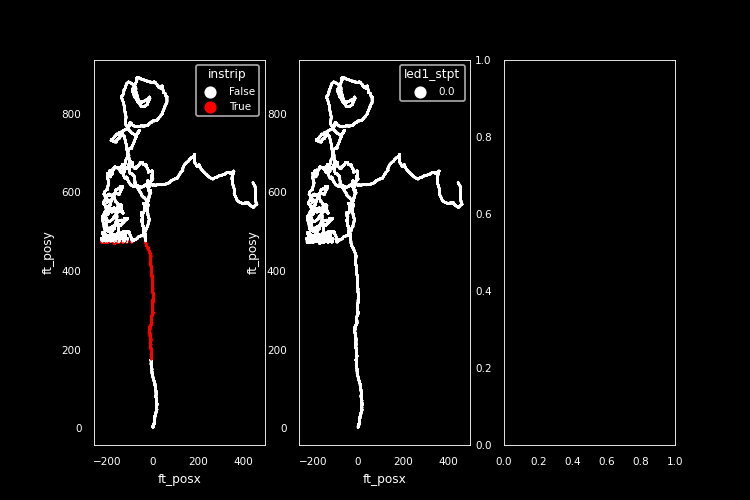

<IPython.core.display.Javascript object>


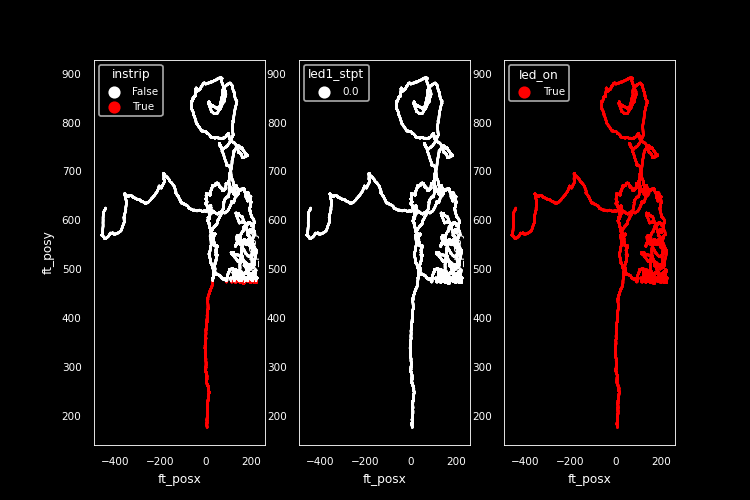

In [166]:
check_leds = True
if check_leds:
    fpath = logdf['filepath'].iloc[1]
    # load raw
    df0 = pd.read_csv(fpath, encoding='latin' )
    if 'instrip' not in df0.columns:
        mfc_params = butil.get_mfc_params(df0)
        df0['instrip'] = df0[mfc_params['odor_mfc']]>0
    # get processed 
    df_ = butil.load_dataframe(fpath, experiment=experiment)
    df_ = butil.correct_manual_conditions(df_, experiment, logdf=logdf)
    df_ = butil.process_df(df_, verbose=False)
    print(df0.columns)

    fig, axn = pl.subplots(1,3)
    sns.scatterplot(data=df0, x='ft_posx', y='ft_posy', hue='instrip', ax=axn[0],
                    palette={True: 'r', False: 'w'}, s=2, edgecolor='none')
    sns.scatterplot(data=df0, x='ft_posx', y='ft_posy', hue='led1_stpt', ax=axn[1],
                    palette={True: 'r', False: 'w'}, s=2, edgecolor='none')

    fig, axn = pl.subplots(1,3)
    sns.scatterplot(data=df_, x='ft_posx', y='ft_posy', hue='instrip', ax=axn[0],
                    palette={True: 'r', False: 'w'}, s=2, edgecolor='none')
    sns.scatterplot(data=df_, x='ft_posx', y='ft_posy', hue='led1_stpt', ax=axn[1],
                    palette={True: 'r', False: 'w'}, s=2, edgecolor='none')
    sns.scatterplot(data=df_, x='ft_posx', y='ft_posy', hue='led_on', ax=axn[2],
                    palette={True: 'r', False: 'w'}, s=2, edgecolor='none')

# get combined df

In [167]:
importlib.reload(butil)

<module 'behavior' from '/home/julianarhee/Repositories/plume-tracking/behavior.py'>

In [168]:
create_new=True
strip_width=50
strip_sep=1000
# ---------------------------------
# log_files = butil.get_log_files(src_dir=srcdir, experiment=experiment, verbose=False, is_gdrive=False,
#                         return_loginfo=False)
# is_csv = False
df_fpath = os.path.join(savedir, '{}.pkl'.format(experiment))
if not create_new:
    df0_all = butil.load_df(df_fpath)
else:
    if experiment=='T_plume':
        tmp_fpath = os.path.join(savedir, 'from_andy', 'T_plume.p')
        print(fpath)
        with open(tmp_fpath, 'rb') as f:
            dfdict = pkl.load(f)
        if create_new:
            d_list = []
            for fi, (fn, df_) in enumerate(dfdict.items()):
                if 'instrip' not in df_['data'].columns:
                    print(fn)
                df_['data']['filename'] = fn
                df0 = df_['data'].copy()
                # convert timestamp str into datetime obj, convert to sec
                datefmt  = '%m/%d/%Y-%H:%M:%S.%f'
                df0['time'] = df0['timestamp'].apply(lambda x: \
                                        time.mktime(x.timetuple()) \
                                        + x.microsecond / 1E6 ).astype('float')
                df0['rel_time'] = df0['time'] - df0['time'].iloc[0]
                # convert datestr
                df0['date'] = df0['timestamp'].apply(lambda s: int(s.date().strftime("%Y%m%d")))
                # convert ft_heading to make it continuous and in range (-pi, pi)
                if 'ft_heading' in df0.columns:
                    p = util.unwrap_and_constrain_angles(df0['ft_heading'].values)
                    df0['ft_heading'] = p #-p 
                df0 = butil.process_df(df0, bout_thresh=0.25)
                # df_z = putil.zero_trajectory(df0)
                df0['fly_id'] = fi
                df0['condition'] = experiment
                df0['experiment'] = experiment
                d_list.append(df0)
            df0_all = pd.concat(d_list, axis=0)
        #     with open(combined_fpath, 'wb') as f:
        #         pkl.dump(df0_all, f)
    else:
        df0_all = butil.load_combined_df(log_files=logdf['filepath'].values, logdf=logdf, src_dir=srcdir,
                                is_csv=False, experiment=experiment, combined_fbase=experiment,
                                savedir=savedir, save_errors=False, create_new=create_new,
                                parse_filename=True, remove_invalid=True, process=True)

Processing 13 tracking files.
Creating combined df
[WARNING] ['03072022-154741T_Plume_Fly7_T1(fictrac lost tracking)']: Found bad skips, removing 146 of 23700 samples.
[WARNING] ['03142022-190502_T_plume_Fly10(lost tracking)']: Found bad skips, removing 9477 of 34737 samples.
Correcting experiment conditions: T-plume
Saving combined df to: /home/julianarhee/edgetracking-googledrive/Edge_Tracking/Data/jyr/plume_geometries/data


In [177]:
print("There are {} unique fly IDs.".format(len(df0_all['fly_id'].unique())))
df0_all['fly_id'].unique()

There are 13 unique fly IDs.


array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12])

In [178]:
condition_list = df0_all['condition'].unique()
print("Found {} conditions:".format(len(condition_list)))
for c in condition_list:
    print(c)

Found 1 conditions:
T-plume


In [179]:
if experiment in ['15-degree', '45-degree']:
    reinforced = [c for c in condition_list if 'reinforced' in c or 'reinforcement' in c]
    not_reinforced = [c for c in condition_list if c not in reinforced]
    #reinforced = [c for c in condition_list if 'reinforced' in c or 'reinforcement' in c]
    #not_reinforced = [c for c in condition_list if c not in reinforced]
    df0_all.loc[df0_all['condition'].isin(reinforced), 'condition'] = 'reinforced'
    df0_all.loc[df0_all['condition'].isin(not_reinforced), 'condition'] = 'not_reinforced'
else:
    df0_all['condition'] = 't_plume'

In [180]:
df0_all['flipped'] = False
if experiment=='15-degree':
    for fn, df_ in df0_all.groupby('filename'):
        odor_dir = logdf.loc[logdf['log']=='{}.log'.format(fn)]['direction'].values[0]
        if odor_dir=='left':
            print("flipping")
            # flip
            fp_ = butil.fliplr_dataframe(df_)
            df0_all.loc[df0_all['filename']==fn] = fp_
            df0_all.loc[df0_all['filename']==fn, 'flipped'] = True

In [181]:
df0_all['filename'].nunique()

13

<IPython.core.display.Javascript object>


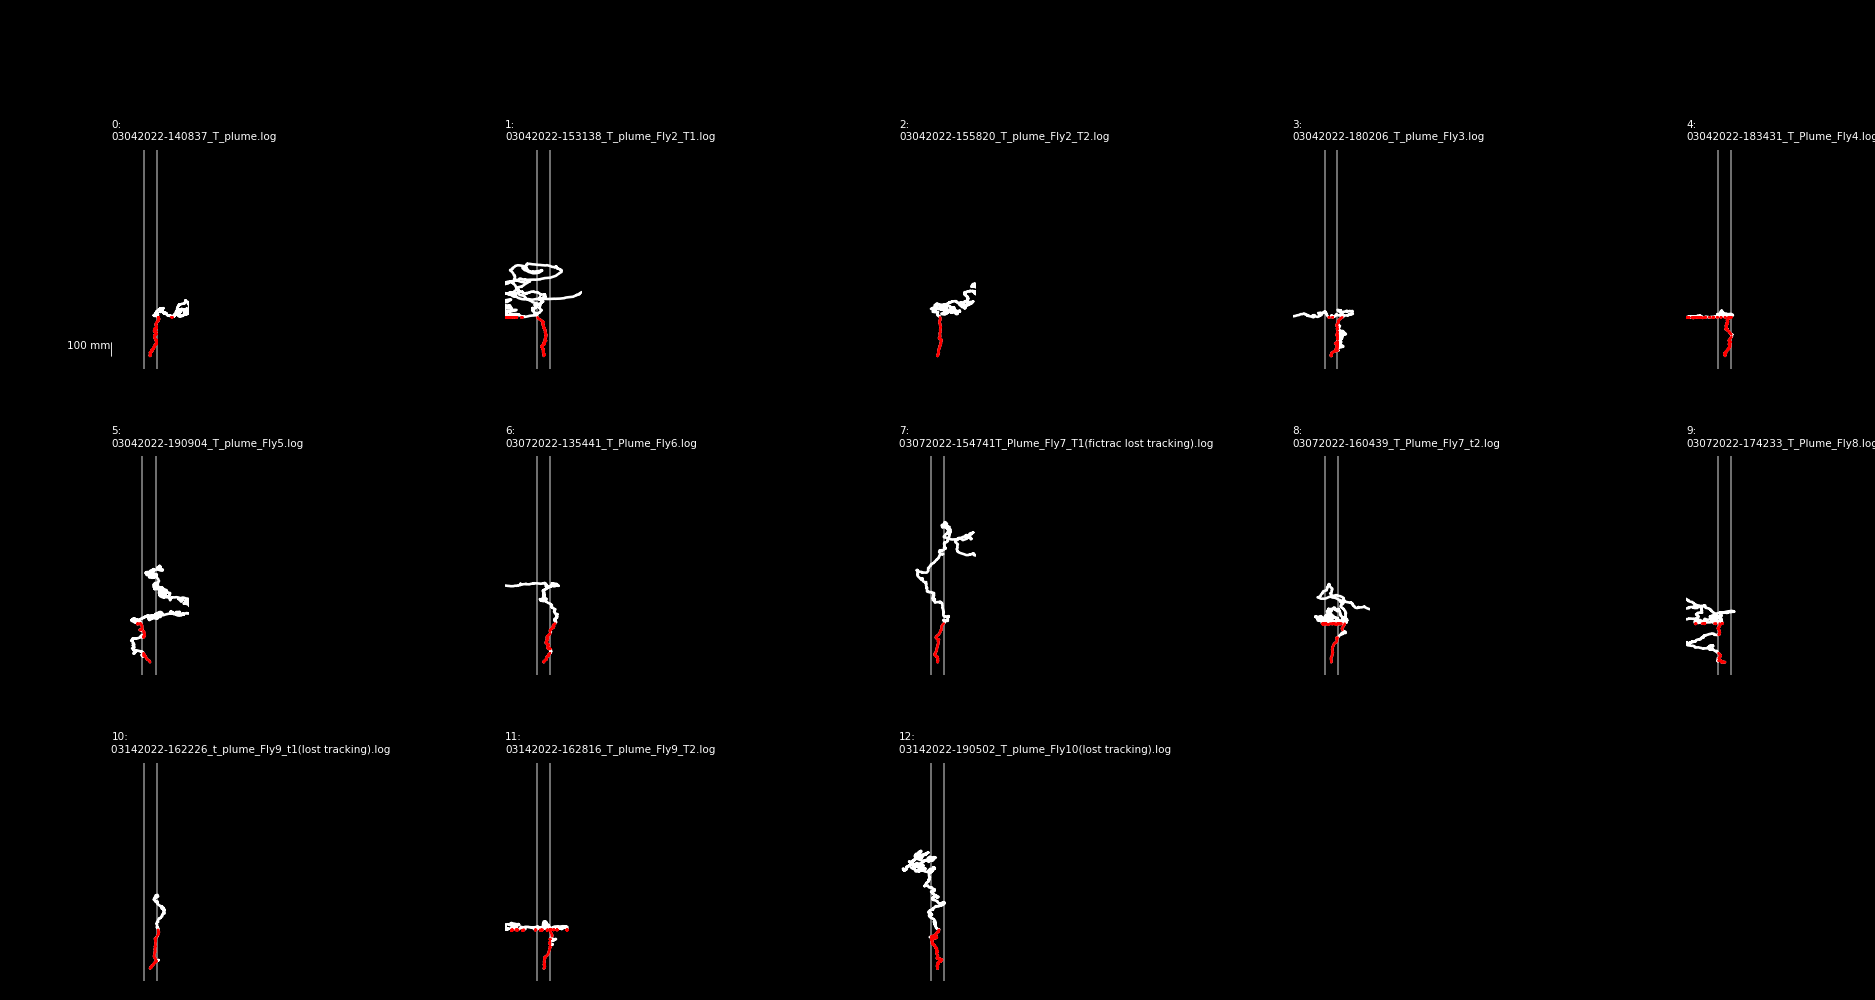

In [182]:
fig = putil.plot_array_of_trajectories(df0_all, nr=3, nc=5)

# save

In [183]:
if create_new: # save
    print("Saving combined df to: {}".format(df_fpath))
    butil.save_df(df0_all, df_fpath)
create_new=False

Saving combined df to: /home/julianarhee/edgetracking-googledrive/Edge_Tracking/Data/jyr/plume_geometries/data/T-plume.pkl
